In [614]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import kurtosis
from scipy.optimize import minimize
from arch import arch_model
import warnings
import os

In [615]:
warnings.filterwarnings("ignore")

# Getting the Data

In [616]:
start_date = '2022-12-24'
end_date = '2025-12-24'

In [617]:
def get_data(asset,start_date,end_date,interval):
    asset_series = yf.download(asset,start=start_date,end=end_date,interval=interval)
    log_returns = np.log((asset_series['Close'][asset]/ asset_series['Close'][asset].shift(1))).dropna()
    
    return log_returns

In [618]:
nifty_log_data = get_data("^NSEI",start_date,end_date,'1d')
nifty_log_data

[*********************100%***********************]  1 of 1 completed


Date
2022-12-27    0.006512
2022-12-28   -0.000541
2022-12-29    0.003773
2022-12-30   -0.004722
2023-01-02    0.005077
                ...   
2025-12-17   -0.001608
2025-12-18   -0.000116
2025-12-19    0.005826
2025-12-22    0.007902
2025-12-23    0.000181
Name: ^NSEI, Length: 739, dtype: float64

In [619]:
sensex_log_data = get_data("^BSESN",start_date,end_date,'1d')
sensex_log_data

[*********************100%***********************]  1 of 1 completed


Date
2022-12-27    0.005943
2022-12-28   -0.000281
2022-12-29    0.003664
2022-12-30   -0.004807
2023-01-02    0.005361
                ...   
2025-12-17   -0.001421
2025-12-18   -0.000921
2025-12-19    0.005284
2025-12-22    0.007485
2025-12-23   -0.000498
Name: ^BSESN, Length: 737, dtype: float64

In [620]:
gold_log_data = get_data("GC=F",start_date,end_date,'1d')
gold_log_data

[*********************100%***********************]  1 of 1 completed


Date
2022-12-28   -0.003809
2022-12-29    0.006396
2022-12-30    0.000110
2023-01-03    0.010931
2023-01-04    0.007096
                ...   
2025-12-17    0.009940
2025-12-18   -0.001842
2025-12-19    0.005034
2025-12-22    0.018897
2025-12-23    0.008558
Name: GC=F, Length: 752, dtype: float64

In [621]:
sp500_log_data = get_data("^GSPC",start_date,end_date,'1d')
sp500_log_data

[*********************100%***********************]  1 of 1 completed


Date
2022-12-28   -0.012093
2022-12-29    0.017311
2022-12-30   -0.002544
2023-01-03   -0.004009
2023-01-04    0.007511
                ...   
2025-12-17   -0.011660
2025-12-18    0.007903
2025-12-19    0.008779
2025-12-22    0.006416
2025-12-23    0.004540
Name: ^GSPC, Length: 750, dtype: float64

In [622]:
usdinr_log_data = get_data("USDINR=X",start_date,end_date,'1d')
usdinr_log_data

[*********************100%***********************]  1 of 1 completed

Date
2022-12-27    0.003611
2022-12-28   -0.001531
2022-12-29    0.000916
2022-12-30   -0.000204
2023-01-02   -0.001030
                ...   
2025-12-17    0.001893
2025-12-18   -0.005902
2025-12-19   -0.001748
2025-12-22   -0.007627
2025-12-23    0.000378
Name: USDINR=X, Length: 778, dtype: float64

In [623]:
oil_log_data = get_data("CL=F",start_date,end_date,'1d')
oil_log_data

[*********************100%***********************]  1 of 1 completed


Date
2022-12-28   -0.007193
2022-12-29   -0.007117
2022-12-30    0.023447
2023-01-03   -0.042375
2023-01-04   -0.054631
                ...   
2025-12-17    0.012049
2025-12-18    0.003747
2025-12-19    0.009042
2025-12-22    0.023547
2025-12-23    0.006358
Name: CL=F, Length: 752, dtype: float64

# Analysis of the Data

In [624]:
assets = {
    "Nifty 50":nifty_log_data,
    "Sensex":sensex_log_data,
    "Gold":gold_log_data,
    "S&P 500":sp500_log_data,
    "USDINR":usdinr_log_data,
    "Oil":oil_log_data
}

In [625]:
for name,value in assets.items():
    asset_kurtosis = kurtosis(value)
    print(name,"Kurtosis: ", asset_kurtosis)

Nifty 50 Kurtosis:  7.512814484357156
Sensex Kurtosis:  6.772825008811417
Gold Kurtosis:  2.597119812962898
S&P 500 Kurtosis:  13.954266573085803
USDINR Kurtosis:  18.8733907055223
Oil Kurtosis:  1.0349517799385568


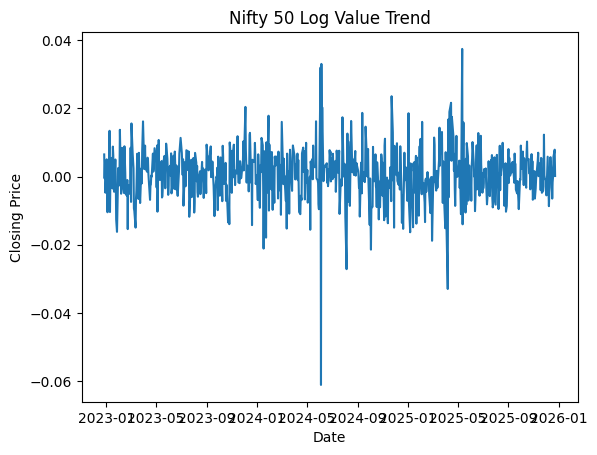

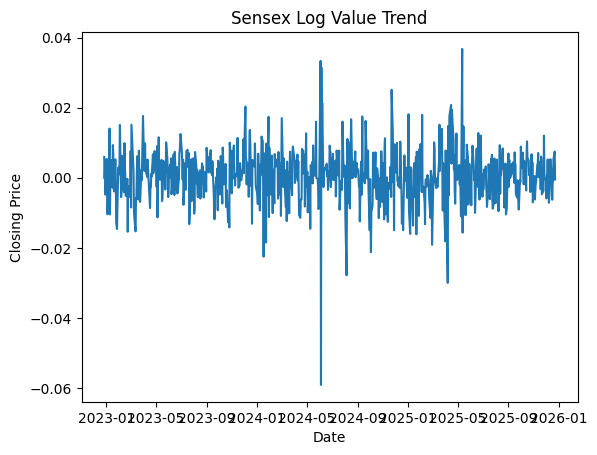

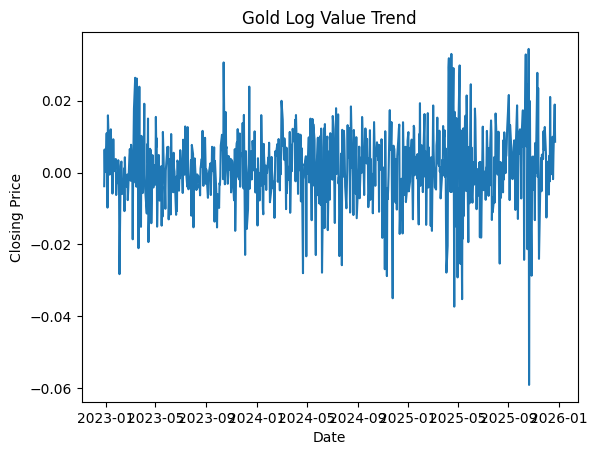

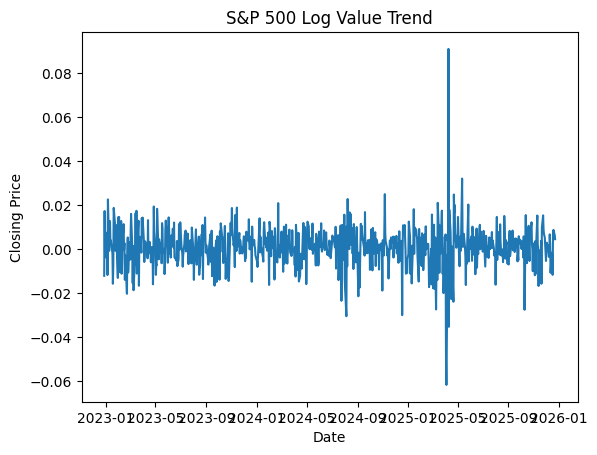

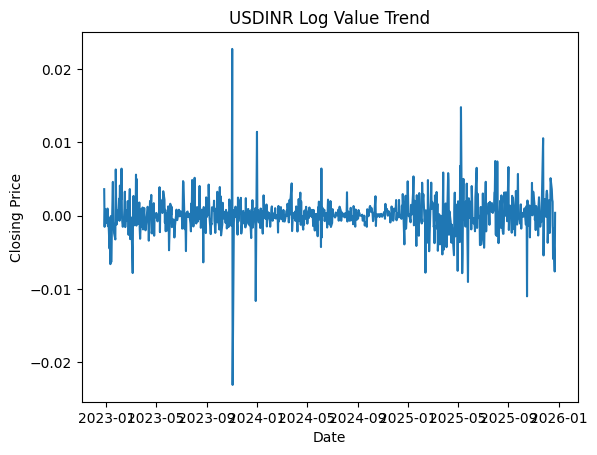

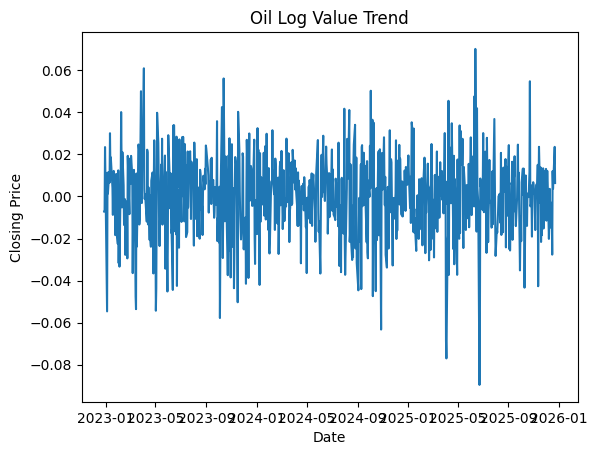

In [626]:
for name,value in assets.items():
    plt.plot(value)
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"{name} Log Value Trend")
    plt.show()

# ACF and PACF

In [627]:
# 3 years data is roughly 750 data points
# So lag value for be root(750), that is roughly, 27
def plot_acf_pacf(df):
    for name,value in df.items():
        acf_values = acf(value, nlags=27)
        pacf_values = pacf(value,nlags=27)
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        plot_acf(value,lags = 27, ax=axes[0])
        axes[0].set_title(f"ACF for {name}")
        
        plot_pacf(value,lags = 27, ax=axes[1])
        axes[1].set_title(f"PACF for {name}")
        
        plt.tight_layout()
        plt.show()

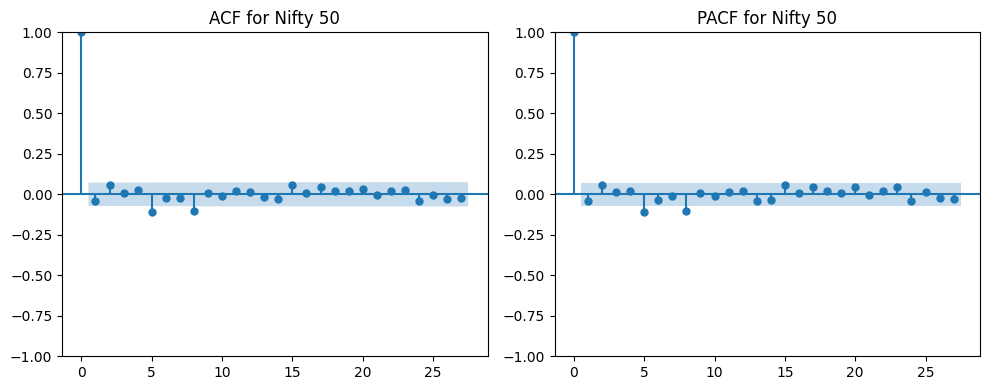

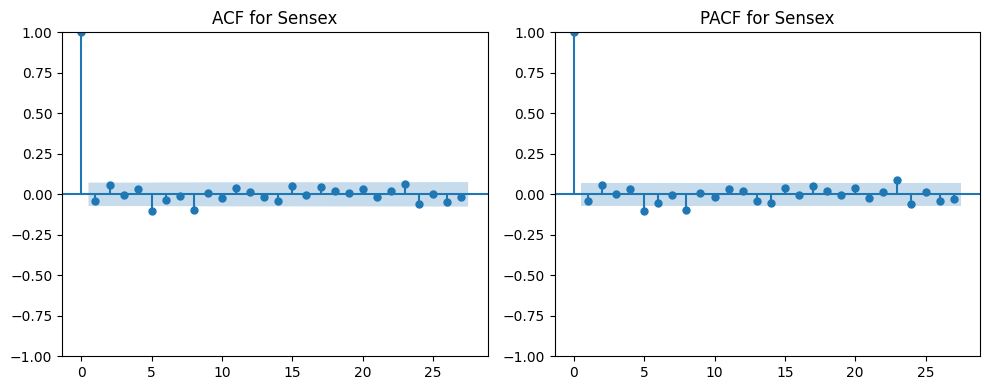

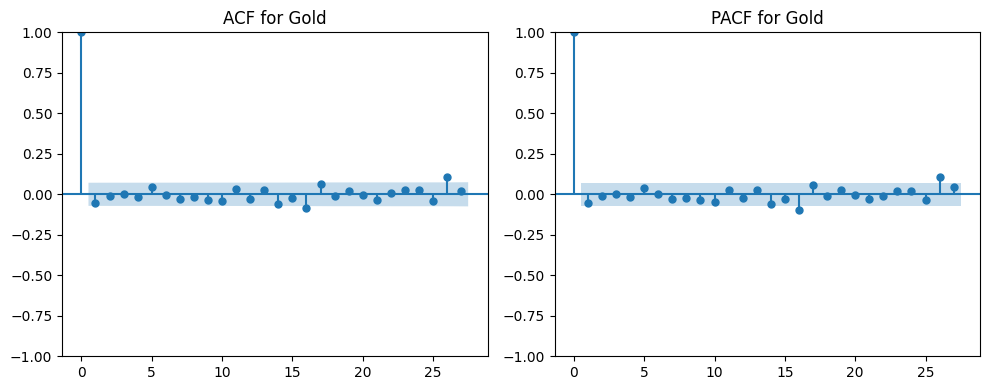

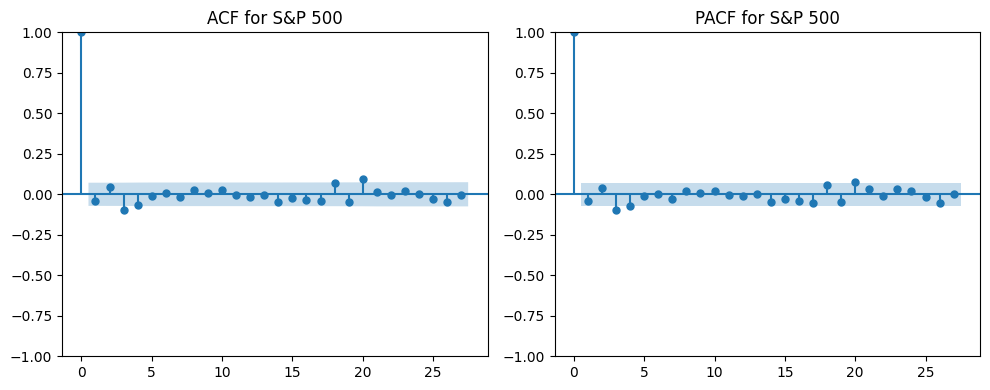

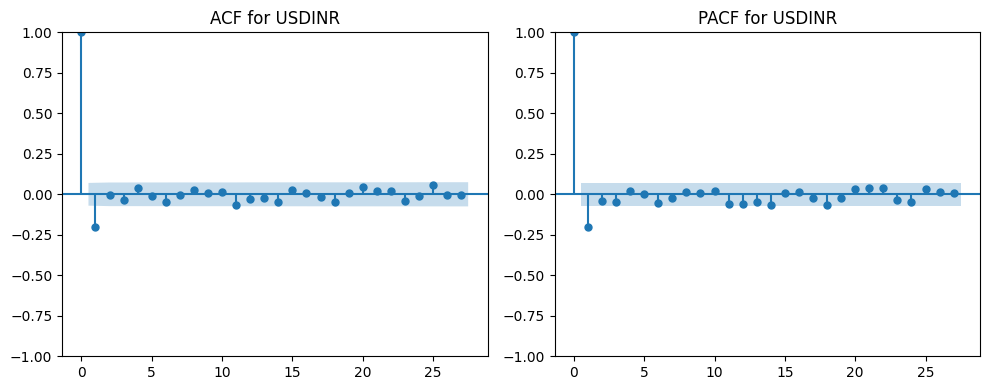

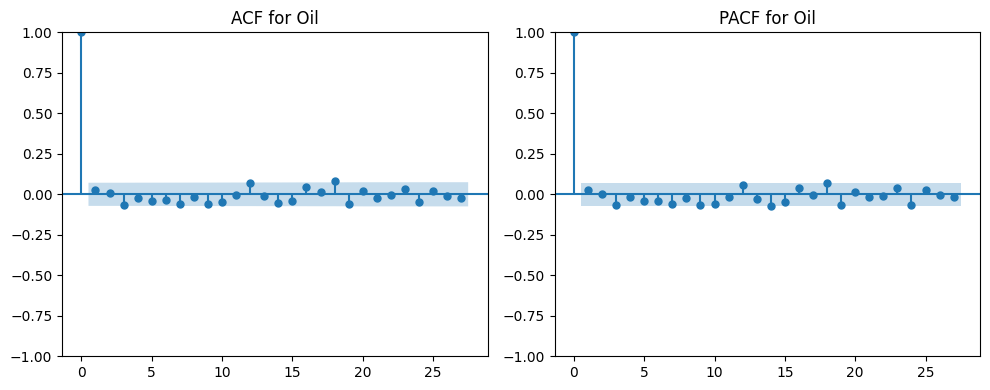

In [628]:
plot_acf_pacf(assets)

# ARIMA

In [629]:
def ARIMA_model(df):
    arima_model = ARIMA(df,order = (0,0,1))
    arima_fit = arima_model.fit()
    
    return arima_fit

In [630]:
os.makedirs("ARIMA/Summary",exist_ok=True)

for name,value in assets.items():
    result = ARIMA_model(value)
    
    with open(f"ARIMA/Summary/{name}.txt", "w") as f:
        f.write(result.summary().as_text())

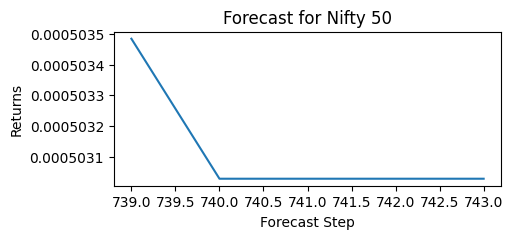

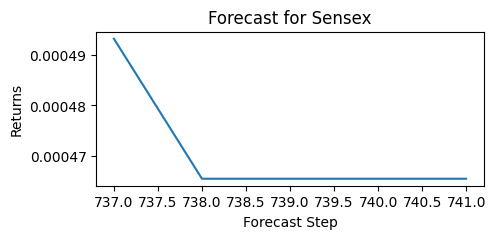

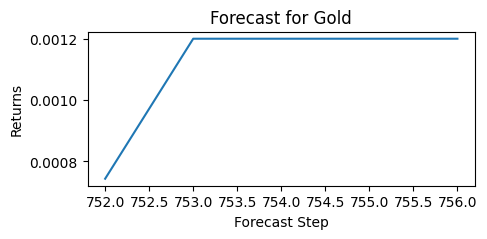

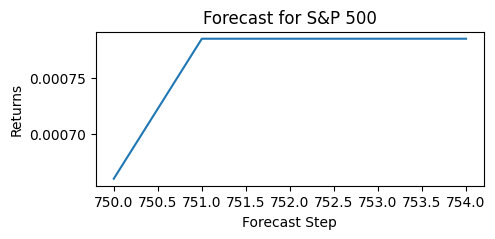

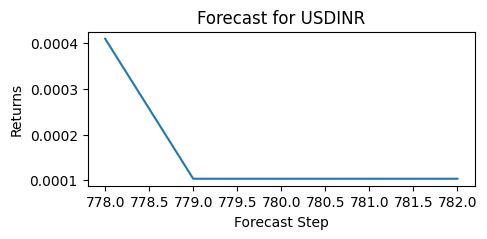

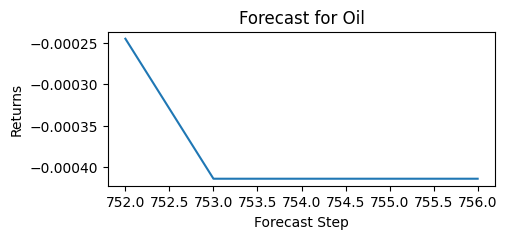

In [631]:
for name,value in assets.items():
    results = ARIMA_model(value)
    
    arima_forecast = results.forecast(steps = 5)
    # print(arima_forecast)
    
    plt.figure(figsize=(5,2))
    plt.plot(arima_forecast)
    plt.title(f"Forecast for {name}")
    plt.xlabel("Forecast Step")
    plt.ylabel("Returns")
    plt.show()

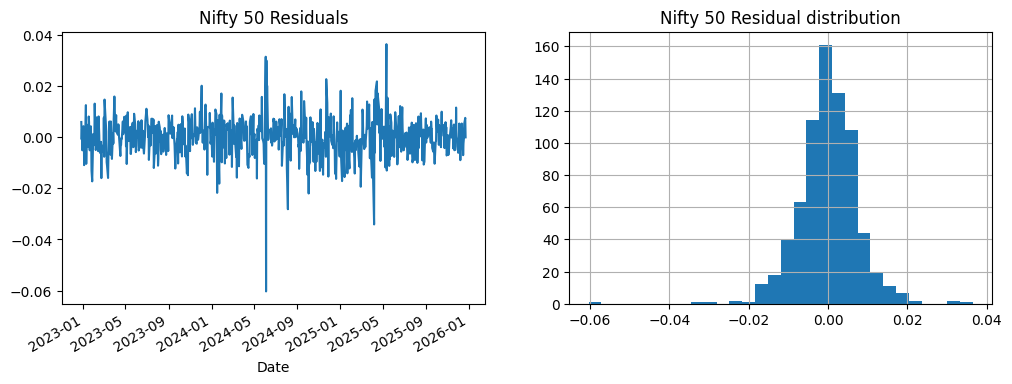

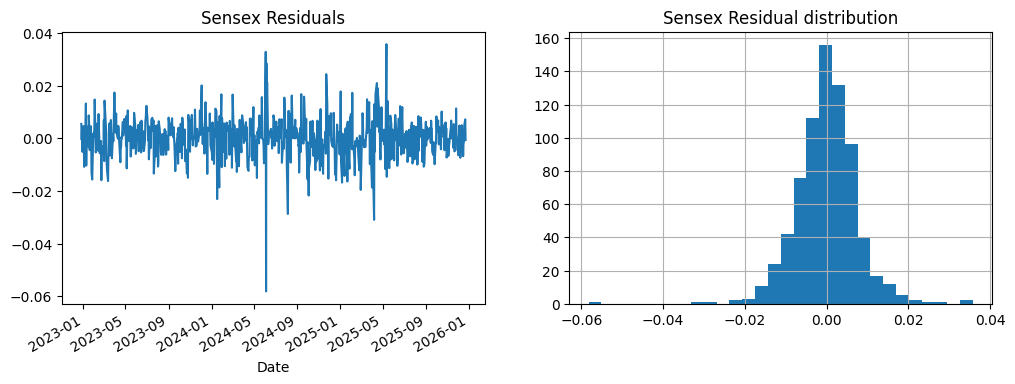

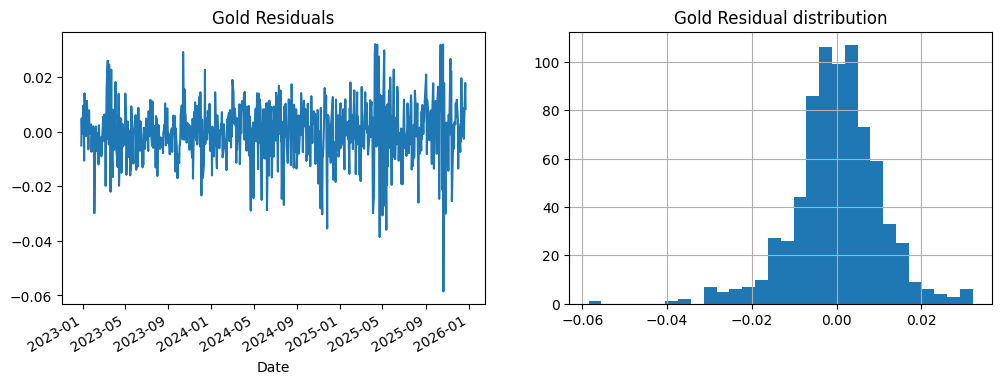

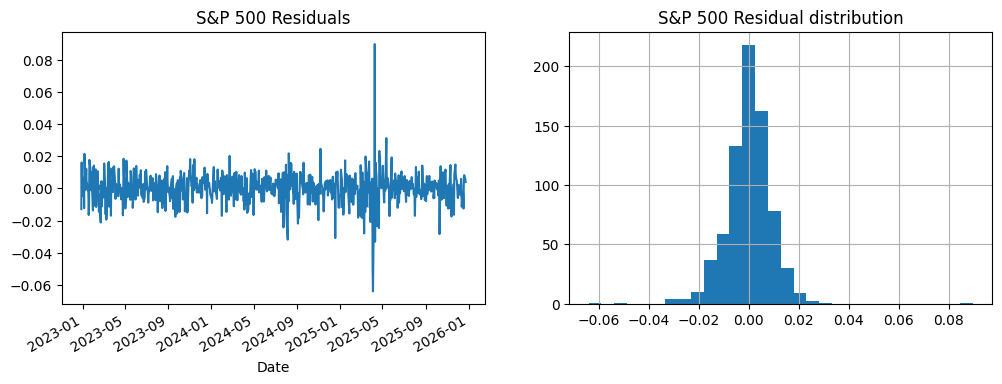

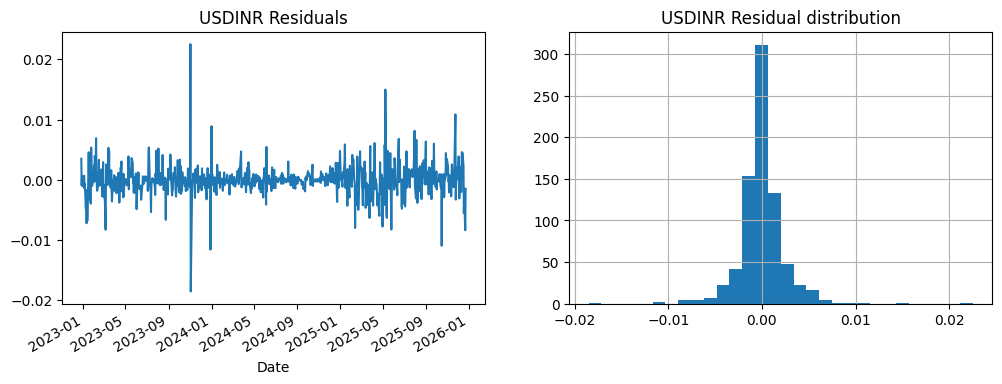

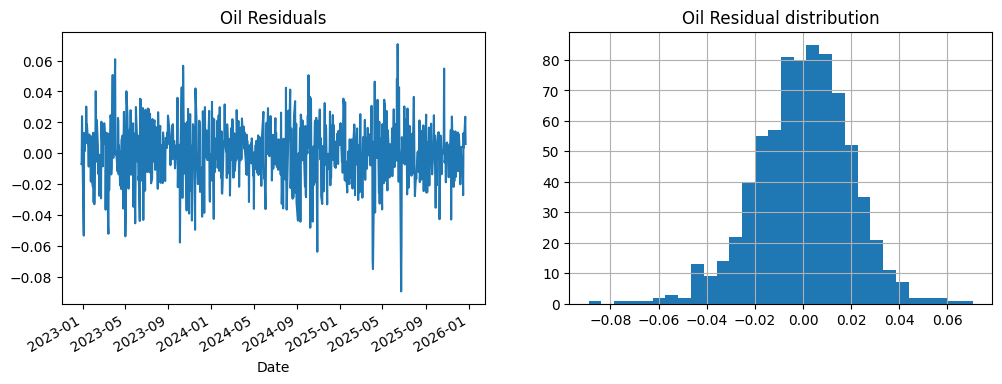

In [632]:
for name,value in assets.items():
    results = ARIMA_model(value)
    residual = results.resid
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    residual.plot(title=f"{name} Residuals")

    plt.subplot(1,2,2)
    residual.hist(bins=30)
    plt.title(f"{name} Residual distribution")
    plt.show()

# GARCH

In [633]:
def GARCH_model(df):
    garch_model = arch_model(df,mean="Constant",vol="GARCH",p=1,q=1,dist="t")
    garch_fit = garch_model.fit(disp="off",options={"maxiter": 5000})
    
    return garch_fit

In [634]:
os.makedirs("GARCH/Summary", exist_ok=True)

for name,value in assets.items():
    result = GARCH_model(value)
        
    with open(f"GARCH/Summary/{name}.txt", "w") as f:
        f.write(result.summary().as_text())

In [635]:
os.makedirs("GARCH/Conditional Volatility", exist_ok=True)

for name,value in assets.items():
    results = GARCH_model(value)
    
    cv = results.conditional_volatility
    
    with open(f"GARCH/Conditional Volatility/{name}.txt", "w") as f:
        f.write(cv.to_string()) 

In [636]:
maxU,maxL = -1000,-1000

for name,value in assets.items():
    results = GARCH_model(value)
    
    garch_forecast = results.forecast(horizon = 5)
    garch_vol_forecast = np.sqrt(garch_forecast.variance.iloc[-1])
    
    upper_band,lower_band = [],[]
    
    for step,sigma in enumerate(garch_vol_forecast, start = 1): 
        upper = value[-1] * (1 + sigma)
        upper_band.append(upper)
        
        lower = value[-1] * (1 - sigma)
        lower_band.append(lower)
        
        maxU = max(maxU,upper)
        maxL = max(maxL,lower)
    
    print("Maximum Upper Value: ",maxU)
    print("Maximum Lower Value: ",maxL)
    print("")
    
    maxU,maxL = -1000,-1000

Maximum Upper Value:  0.00019071852620809613
Maximum Lower Value:  0.0001773368469874487

Maximum Upper Value:  -0.0005088648383177656
Maximum Lower Value:  -0.00047659166190726853

Maximum Upper Value:  0.008643579275920698
Maximum Lower Value:  0.008473475320200763

Maximum Upper Value:  0.008327791087963065
Maximum Lower Value:  0.0007582432829568607

Maximum Upper Value:  0.0011404811013640333
Maximum Lower Value:  -5.608318636430112e-05

Maximum Upper Value:  0.006466597056494835
Maximum Lower Value:  0.0062526069473663425



# Correlation Matrix

In [637]:
merged_df = pd.concat(
    [
        nifty_log_data,
        sensex_log_data,
        usdinr_log_data,
        gold_log_data,
        sp500_log_data,
        oil_log_data
    ],
    axis=1,
    join="inner"
).reset_index()

merged_df = merged_df.set_index('Date').dropna()
merged_df.head()

,^NSEI,^BSESN,USDINR=X,GC=F,^GSPC,CL=F
Date,,,,,,
2022-12-28,-0.000541,-0.000281,-0.001531,-0.003809,-0.012093,-0.007193
2022-12-29,0.003773,0.003664,0.000916,0.006396,0.017311,-0.007117
2022-12-30,-0.004722,-0.004807,-0.000204,0.000110,-0.002544,0.023447
2023-01-03,0.001927,0.002064,-0.000529,0.010931,-0.004009,-0.042375
2023-01-04,-0.010454,-0.010443,0.000963,0.007096,0.007511,-0.054631


In [638]:
merged_df.rename(columns={"^BSESN":"Sensex","GC=F": "Gold", "^NSEI": "Nifty","USDINR=X":"USDINR","^GSPC": "SP500", "CL=F": "Oil"}, inplace=True)
merged_df

,Nifty,Sensex,USDINR,Gold,SP500,Oil
Date,,,,,,
2022-12-28,-0.000541,-0.000281,-0.001531,-0.003809,-0.012093,-0.007193
2022-12-29,0.003773,0.003664,0.000916,0.006396,0.017311,-0.007117
2022-12-30,-0.004722,-0.004807,-0.000204,0.000110,-0.002544,0.023447
2023-01-03,0.001927,0.002064,-0.000529,0.010931,-0.004009,-0.042375
2023-01-04,-0.010454,-0.010443,0.000963,0.007096,0.007511,-0.054631
...,...,...,...,...,...,...
2025-12-17,-0.001608,-0.001421,0.001893,0.009940,-0.011660,0.012049
2025-12-18,-0.000116,-0.000921,-0.005902,-0.001842,0.007903,0.003747
2025-12-19,0.005826,0.005284,-0.001748,0.005034,0.008779,0.009042


In [639]:
merged_corr = merged_df.corr()

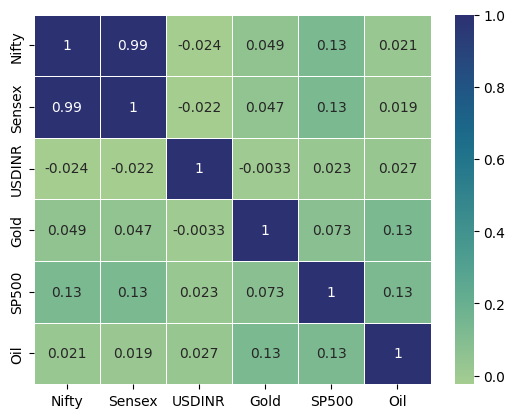

In [640]:
ax = sns.heatmap(merged_corr,annot=True,linewidth=.5,cmap="crest")
plt.show()

### Rolling correlation plots

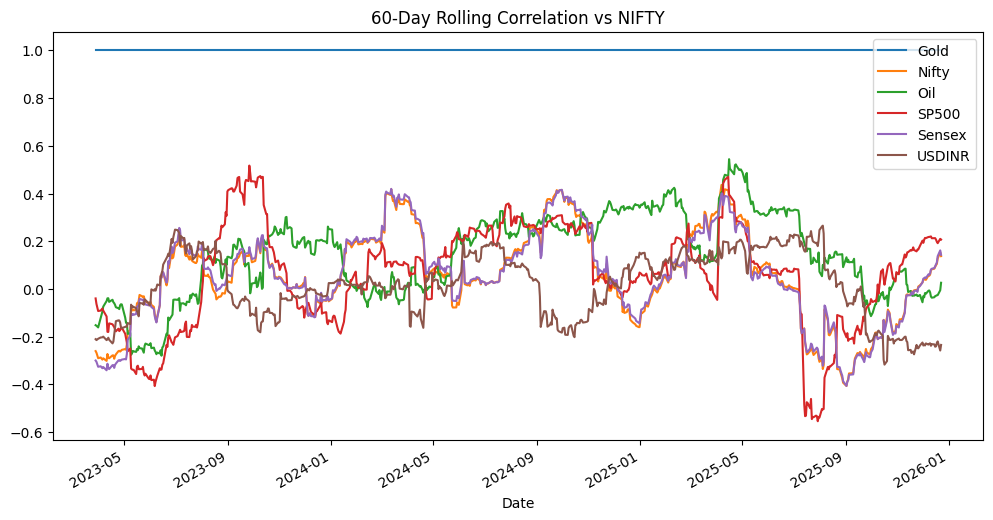

In [641]:
target = "Gold"

gold_rc = merged_df.rolling(60).corr()[target].unstack()

gold_rc.plot(figsize=(12,6), title="60-Day Rolling Correlation vs NIFTY")
plt.legend(loc="upper right")
plt.show()

# Markowitz Model

### Mean and Covariance

In [642]:
mu = merged_df.mean() * 252
cov = merged_df.cov() * 252

### Return and Risk

In [643]:
def portfolio_return(w,mu):
    return float(w @ mu)

def portfolio_risk(w,cov):
    return float((w.T @ cov @ w) ** 0.5)

### Equal Weights Portfolio

In [644]:
equal_weights =  [1/len(assets)] * len(assets)

for w,name in zip(equal_weights,assets.keys()):
    print(name,": ",round(w*100,2),"%")

Nifty 50 :  16.67 %
Sensex :  16.67 %
Gold :  16.67 %
S&P 500 :  16.67 %
USDINR :  16.67 %
Oil :  16.67 %


In [645]:
n = len(mu)
w_equal = np.ones(n) / n

ret_equal = portfolio_return(w_equal, mu)
risk_equal = portfolio_risk(w_equal, cov)

print("Returns :",round(ret_equal * 100,2),"%")
print("Risk :",round(risk_equal * 100,2),"%")

Returns : 11.87 %
Risk : 8.41 %


### Minimum Mean-Variance Model

In [646]:
def portfolio_variance(w,df_corr):
    return w.T @ df_corr @ w

n = len(mu)

w0 = np.ones(n)/n

constraints = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1}) # Sum of all portfolio weights is equal to 1
bounds = tuple((0,1) for _ in range(n))  # No short selling

result = minimize(portfolio_variance,w0,args=(merged_corr,), bounds=bounds, constraints=constraints)

mean_variance_weights = result.x

In [647]:
for name,w in zip(assets.keys(),mean_variance_weights):
    print(name,": ",round(w*100,2),"%")

Nifty 50 :  10.61 %
Sensex :  10.6 %
Gold :  23.78 %
S&P 500 :  19.58 %
USDINR :  17.09 %
Oil :  18.35 %


In [648]:
ret_minvar = portfolio_return(mean_variance_weights, mu)
risk_minvar = portfolio_risk(mean_variance_weights, cov)

print("Returns :",round(ret_minvar * 100,2),"%")
print("Risk :",round(risk_minvar * 100,2),"%")

Returns : 11.59 %
Risk : 8.43 %


### Efficient Frontier

Closed-form efficient frontier assumes unconstrained optimization.
Therefore weights may exceed 100% or become negative, representing leverage and short selling.

In [649]:
def efficient_frontier(mu,cov,target):
    ones = np.ones(len(mu))
    inv_cov = np.linalg.inv(cov)
    
    A = ones.T @ inv_cov @ ones
    B = ones.T @ inv_cov @ mu
    C = mu.T @ inv_cov @ mu
    D = (A*C) - (B*B)
    
    w_mvo = (((C - (B * target))/D) * (inv_cov @ ones) + ((((A*target) - B)/D) * (inv_cov @ mu)))
    
    return w_mvo

In [650]:
targets = np.linspace(mu.min(), mu.max(), 10)
rows = []

for t in targets:
    res = efficient_frontier(mu,cov,t)
    
    frontier_returns = portfolio_return(res, mu)
    frontier_risks = portfolio_risk(res, cov)

    rows.append({
        'target':round(t*100,2),
        "nifty_weights":round(res[0]*100,4),
        "sensex_weights":round(res[1]*100,4),
        "gold_weights":round(res[2]*100,4),
        "sp500_weights":round(res[3]*100,4),
        "usdinr_weights":round(res[3]*100,4),
        "oil_weights":round(res[3]*100,4),
        "return":frontier_returns,
        "risk":frontier_risks
    })
    
frontier_df = pd.DataFrame(rows)
frontier_df

,target,nifty_weights,sensex_weights,gold_weights,sp500_weights,usdinr_weights,oil_weights,return,risk
0,-6.23,-138.8985,143.3141,120.1562,-17.7163,-17.7163,-17.7163,-0.062323,0.064353
1,-2.16,-89.0356,94.9541,107.1284,-10.0936,-10.0936,-10.0936,-0.021644,0.050425
2,1.90,-39.1728,46.5941,94.1007,-2.4708,-2.4708,-2.4708,0.019035,0.040110
3,5.97,10.6900,-1.7659,81.0730,5.1519,5.1519,5.1519,0.059713,0.036598
4,10.04,60.5528,-50.1259,68.0452,12.7747,12.7747,12.7747,0.100392,0.041650
5,14.11,110.4156,-98.4859,55.0175,20.3974,20.3974,20.3974,0.141071,0.052864
6,18.17,160.2785,-146.8459,41.9897,28.0202,28.0202,28.0202,0.181750,0.067224
7,22.24,210.1413,-195.2059,28.9620,35.6429,35.6429,35.6429,0.222428,0.083116
8,26.31,260.0041,-243.5659,15.9342,43.2657,43.2657,43.2657,0.263107,0.099810
9,30.38,309.8669,-291.9259,2.9065,50.8884,50.8884,50.8884,0.303786,0.116963


### Model Comparision

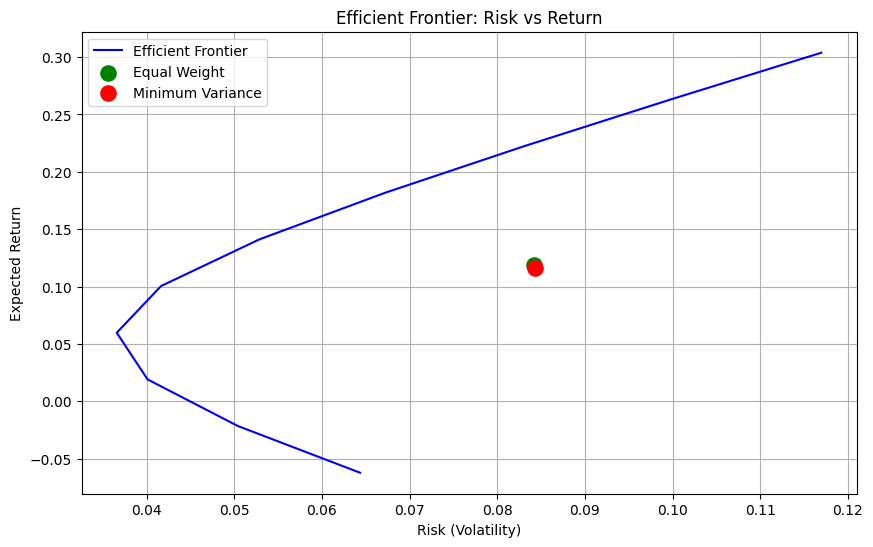

In [651]:
plt.figure(figsize=(10,6))

plt.plot(frontier_df["risk"], frontier_df["return"], label="Efficient Frontier", color="blue")
plt.scatter(risk_equal, ret_equal, color="green", s=120, label="Equal Weight")
plt.scatter(risk_minvar, ret_minvar, color="red", s=120, label="Minimum Variance")

plt.xlabel("Risk (Volatility)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier: Risk vs Return")
plt.legend()
plt.grid(True)
plt.show()

### Portfolio Performance

In [652]:
Total_capital = 100000

In [653]:
merged_simple_returns_df = np.exp(merged_df) - 1
merged_simple_returns_df

,Nifty,Sensex,USDINR,Gold,SP500,Oil
Date,,,,,,
2022-12-28,-0.000541,-0.000281,-0.001530,-0.003802,-0.012021,-0.007167
2022-12-29,0.003780,0.003671,0.000917,0.006416,0.017461,-0.007092
2022-12-30,-0.004711,-0.004795,-0.000204,0.000110,-0.002541,0.023724
2023-01-03,0.001929,0.002067,-0.000529,0.010991,-0.004001,-0.041490
2023-01-04,-0.010399,-0.010388,0.000964,0.007121,0.007539,-0.053165
...,...,...,...,...,...,...
2025-12-17,-0.001607,-0.001420,0.001895,0.009990,-0.011592,0.012122
2025-12-18,-0.000116,-0.000920,-0.005885,-0.001840,0.007934,0.003754
2025-12-19,0.005843,0.005298,-0.001746,0.005047,0.008818,0.009083


In [654]:
def portfolio_performance(df,simple_returns_df,weights,capital):        
    port_ret = simple_returns_df.values @ weights
    cumulative = (1 + port_ret).cumprod()
    final_value = capital * cumulative[-1]
    
    return final_value, cumulative

Equal Weight

In [655]:
final_capital, cumulative = portfolio_performance(assets,merged_simple_returns_df,equal_weights,Total_capital)
print("Final Capital: $", round(final_capital,2))
print("Total Returns: ", round(((final_capital-Total_capital)/Total_capital)*100,2),"%")

Final Capital: $ 144371.31
Total Returns:  44.37 %


Mean Variance

In [663]:
final_capital, cumulative = portfolio_performance(assets,merged_simple_returns_df,mean_variance_weights,Total_capital)
print("Final Capital: $", round(final_capital,2))
print("Total Returns: ", round(((final_capital-Total_capital)/Total_capital)*100,2),"%")

Final Capital: $ 143415.66
Total Returns:  43.42 %


### Efficient Frontier

In [665]:
weight_cols = ["nifty_weights","sensex_weights","gold_weights", "sp500_weights", "usdinr_weights", "oil_weights"]

final_values = []

for _, row in frontier_df.iterrows():
    w = row[weight_cols].values / 100.0
    
    final_value, cumulative = portfolio_performance(assets,merged_simple_returns_df, w, Total_capital)
    final_values.append(final_value)

frontier_df["final_value"] = final_values
frontier_df["portfolio_returns"] = ((frontier_df["final_value"]-Total_capital)/Total_capital) * 100

for t, r, fv in zip(frontier_df["target"], frontier_df["return"], frontier_df["final_value"]):
    print("Target: ", t, "%")
    print('Expected Returns', Total_capital + (Total_capital*r))
    print("Final Capital: $", round(fv,2))
    print("Total Returns: ", round(((fv-Total_capital)/Total_capital)*100,2),"%")
    print("")

Target:  -6.23 %
Expected Returns 93767.71944873428
Final Capital: $ 80958.62
Total Returns:  -19.04 %

Target:  -2.16 %
Expected Returns 97835.59263896434
Final Capital: $ 92392.67
Total Returns:  -7.61 %

Target:  1.9 %
Expected Returns 101903.4658291944
Final Capital: $ 105107.9
Total Returns:  5.11 %

Target:  5.97 %
Expected Returns 105971.33901942447
Final Capital: $ 119194.18
Total Returns:  19.19 %

Target:  10.04 %
Expected Returns 110039.21220965452
Final Capital: $ 134740.25
Total Returns:  34.74 %

Target:  14.11 %
Expected Returns 114107.08539988459
Final Capital: $ 151830.94
Total Returns:  51.83 %

Target:  18.17 %
Expected Returns 118174.95859011465
Final Capital: $ 170547.0
Total Returns:  70.55 %

Target:  22.24 %
Expected Returns 122242.83178034471
Final Capital: $ 190961.63
Total Returns:  90.96 %

Target:  26.31 %
Expected Returns 126310.70497057478
Final Capital: $ 213140.51
Total Returns:  113.14 %

Target:  30.38 %
Expected Returns 130378.57816080484
Final Capit

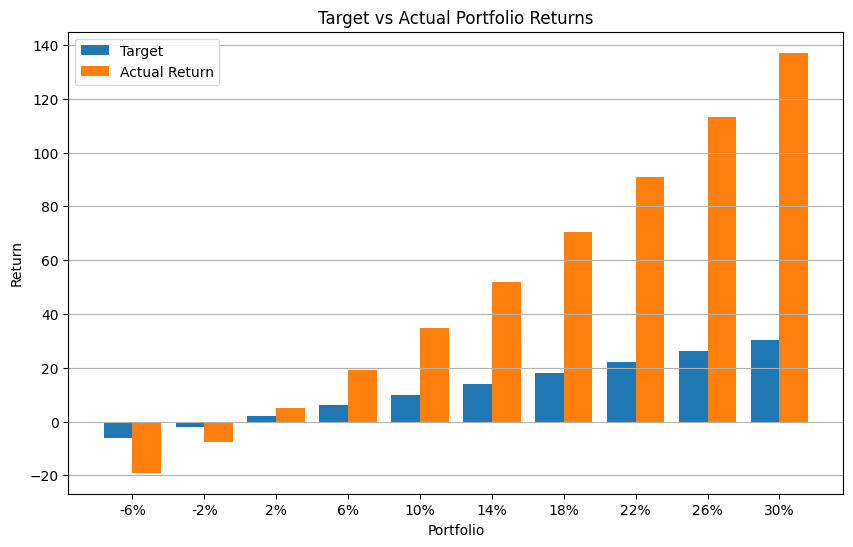

In [669]:
x = np.arange(len(frontier_df))
width = 0.4

plt.figure(figsize=(10,6))
plt.bar(x - width/2, frontier_df["target"], width, label="Target")
plt.bar(x + width/2, frontier_df["portfolio_returns"], width, label="Actual Return")

plt.xticks(x, [f"{t:.0f}%" for t in frontier_df["target"]])
plt.xlabel("Portfolio")
plt.ylabel("Return")
plt.title("Target vs Actual Portfolio Returns")
plt.legend()
plt.grid(True, axis="y")
plt.show()